# Auditd Machine Learning

Focused Attack Types: Reconnaissance, Privilege Escalation, Persistence, and Data Exfiltration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import csv
import os
import transformers
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from tqdm import tqdm
import re
from sklearn.utils.class_weight import compute_class_weight
import torch.nn as nn


/home/ubuntu/Auditd_AI/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


In [4]:
df = pd.read_csv('/home/ubuntu/Auditd_AI/data/standardised_data.csv')



/tmp/ipykernel_894/597938344.py:1: DtypeWarning: Columns (1,11,16,17,20,21,22,23,24,25,26,27,28,29,31,32,33,35,36,37,38,39,40,42,48,59) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/home/ubuntu/Auditd_AI/data/standardised_data.csv')


In [5]:
# Drop columns with no content
for col in df.columns:
    if df[col].value_counts().sum() == 0:
        df = df.drop(columns=[col])
df = df.drop(columns=['LC_NAME'])

In [6]:
# Remove Duplicates
print("Before duplicates:", df.duplicated().sum())
df = df.drop_duplicates()
print("After duplicates:", df.duplicated().sum())

Before duplicates: 558
After duplicates: 0


In [7]:
# Handle Missing Values with NaN or -1
print("Total number of missing values before filling: ", df.isnull().sum().sum())   
for column in df.columns:
    non_null_values = df[column].dropna() # Get non-null values

    if len(non_null_values) == 0:
        continue

    if non_null_values.apply(lambda x: isinstance(x, str)).any():
        df[column] = df[column].astype(str)
        df[column] = df[column].fillna(np.nan)
    
    elif non_null_values.apply(lambda x: isinstance(x, np.integer)).all():
        df[column] = df[column].astype(np.int64)
        df[column] = df[column].fillna(-1)

    elif pd.api.types.is_float_dtype(non_null_values):
        df[column] = df[column].fillna(0)

print("Total number of missing values after filling: ", df.isnull().sum().sum())

Total number of missing values before filling:  1162803
Total number of missing values after filling:  0


## 2.0 Exploratary Data Analysis

### 2.1 Basic Information 

In [8]:
# Basic data info
print("Dataframe shape:", df.shape)
print(f"Total records: {df.shape[0]:,}")
print(f"Total features: {df.shape[1]:,}")


Dataframe shape: (15017, 91)
Total records: 15,017
Total features: 91


### 2.2 Label Distribution

Label distribution:
 label
PRIVILEGE ESCALATION    4909
RECONNAISSANCE          4572
BENIGN                  3017
DATA EXFILTRATION       1273
PERSISTENCE             1246
Name: count, dtype: int64


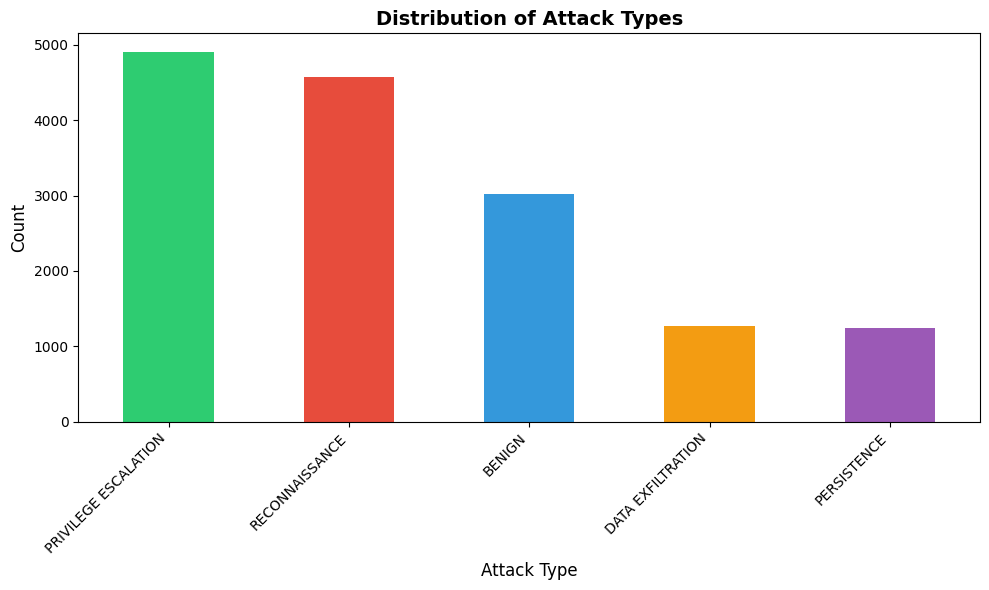

In [9]:
# Label Distribution
total_label = df['label'].value_counts()
print("Label distribution:\n", total_label)

plt.figure(figsize=(10, 6))
total_label.plot(kind='bar', color=['#2ecc71', '#e74c3c', '#3498db', '#f39c12', '#9b59b6'])
plt.title('Distribution of Attack Types', fontsize=14, fontweight='bold')
plt.xlabel('Attack Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

### 2.3 Feature Importance Analysis

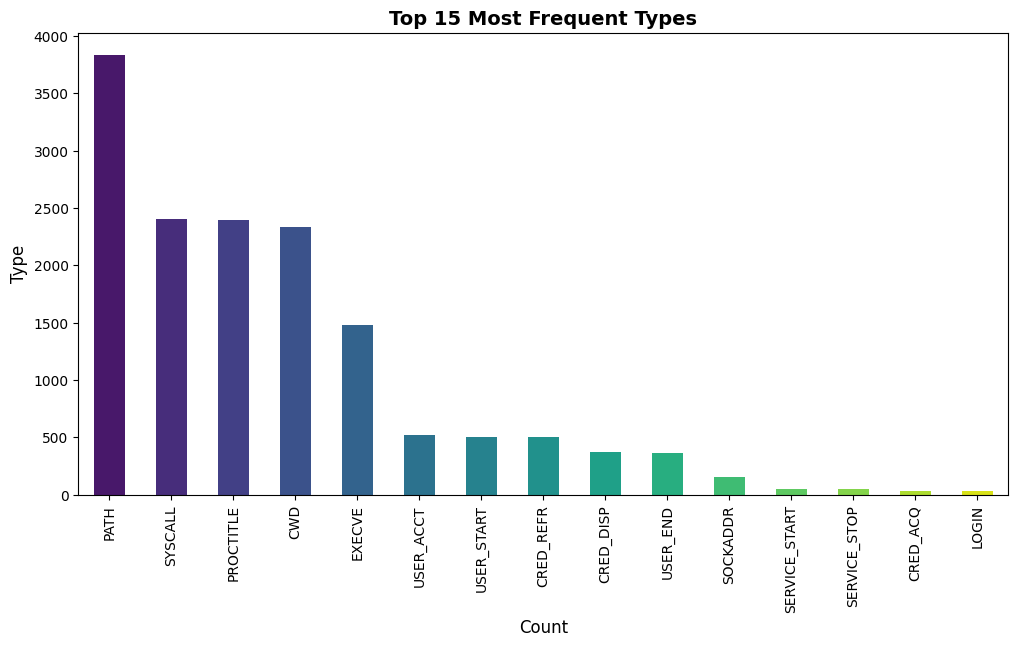

In [10]:
# Feature Importance

if 'type' in df.columns:
    type_dist = df['type'].value_counts()

    plt.figure(figsize=(12, 6))
    type_dist.head(15).plot(kind='bar', color=sns.color_palette('viridis', 15))
    plt.xlabel('Count',fontsize=12)
    plt.ylabel('Type',fontsize=12)
    plt.title('Top 15 Most Frequent Types',fontsize=14, fontweight='bold')

### 2.4 Success Analysis

In [11]:
# Success vs Failure Analysis

if 'success' in df.columns:
    success_dist = df['success'].value_counts()
    print("Success/Failure distribution:")
    print(success_dist)

    # Plot success against label
    print("\nSuccess rate by attack type:")
    for label in df['label'].unique():
        if pd.notna(label):
            subset = df[df['label'] == label]
            success_rate = (subset['success'] == 'yes').sum() / len(subset) * 100
            print(f"{label}: {success_rate:.1f}% successful")

Success/Failure distribution:
success
nan    12612
yes     2215
no       190
Name: count, dtype: int64

Success rate by attack type:
BENIGN: 9.4% successful
RECONNAISSANCE: 16.2% successful
PRIVILEGE ESCALATION: 17.6% successful
DATA EXFILTRATION: 12.6% successful
PERSISTENCE: 13.3% successful


### 2.5 Correlation Matrix

In [12]:
# Drop columns with zero variance and analyze correlation
columns_to_drop = df.columns[df.nunique() <= 1]
df = df.drop(columns=columns_to_drop)

Numeric columns used for correlation analysis: {numeric_cols}


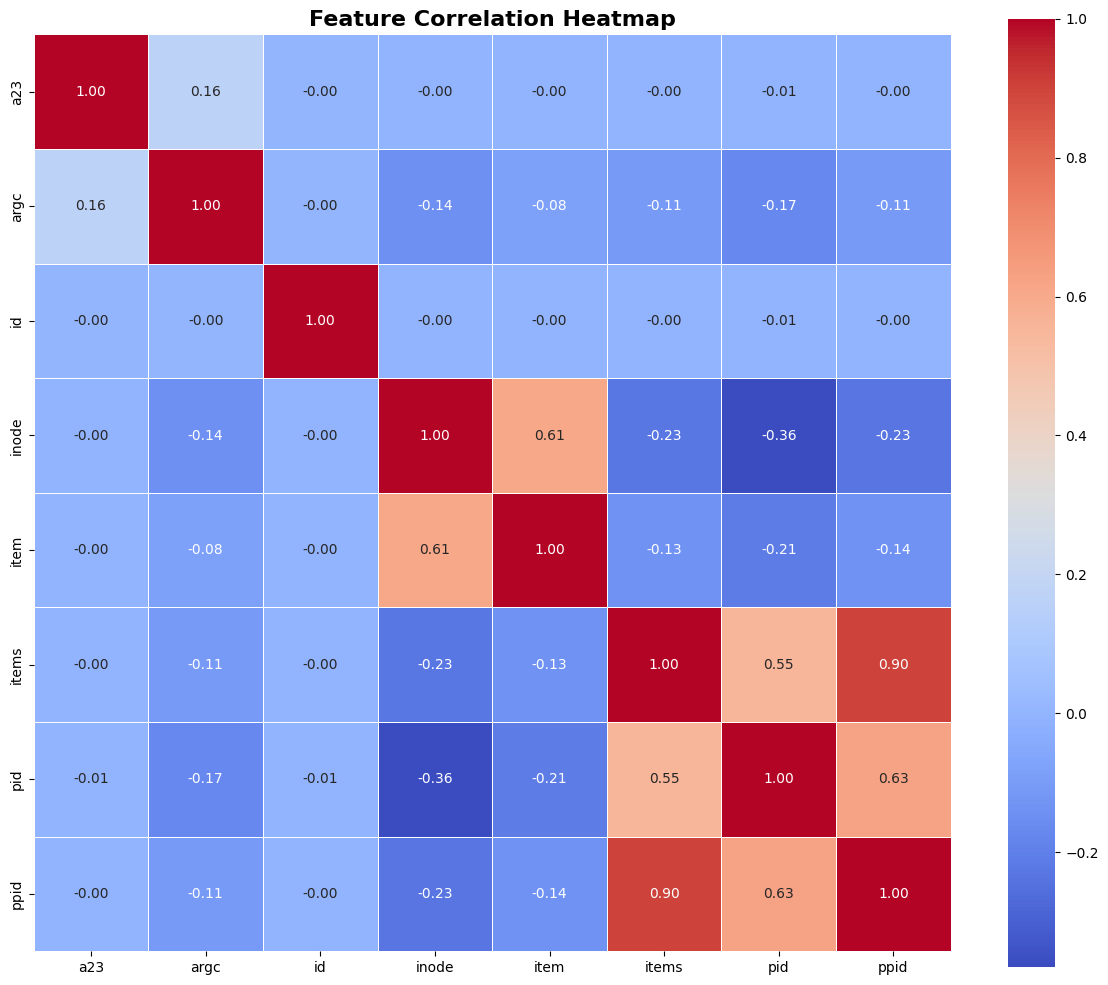

In [13]:
# Correlation Alaysis
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols) > 1:
    print("Numeric columns used for correlation analysis: {numeric_cols}")
    corr_matrix = df[numeric_cols].corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=.5)
    plt.title("Feature Correlation Heatmap", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

### 2.6 Class Imbalance

In [14]:
class_imbalance = df['label'].value_counts(normalize=True) * 100
class_imbalance

label
PRIVILEGE ESCALATION    32.689618
RECONNAISSANCE          30.445495
BENIGN                  20.090564
DATA EXFILTRATION        8.477059
PERSISTENCE              8.297263
Name: proportion, dtype: float64

## 3.0 Feature Engineering 

In [15]:
columns_to_drop = ['LANG', 'PATH']

In [16]:
"""
Timestamps are essential in audit logs for tracking events over time. They help in sequencing events, correlating activities, and identifying patterns or anomalies.
So we need to extract timestamp from 'msg' column and separate audit_id as well.
"""
extracted = df['msg'].str.extract(r'audit\((\d{2}/\d{2}/\d{4}\s\d{2}:\d{2}:\d{2}\.\d{3}):(\d+)\)')
df['timestamp'] = extracted[0]
df['audit_id'] = extracted[1]

# Drop column 'msg' after extraction
df = df.drop(columns=['msg'])

df['timestamp'].head(5)

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%m/%d/%Y %H:%M:%S.%f', errors='coerce')

# Sort by time (Important as our logs are ran sequentially)
df = df.sort_values('timestamp').reset_index(drop=True)


In [17]:
consolidated = []

"""
Group by audit_id and consolidate events into single records. 
At the same time, we remove unnecessary fields and extract relevant information from each event type.
"""

# Group by audit_id and consolidate events into single records. 
# Group by creates pairs of (key, DataFrame). In this case, we have (audit_id, group).
for audit_id, group in tqdm(df.groupby('audit_id'), desc="Consolidating events"):
    event = {
        'audit_id': audit_id,
        'timestamp': group['timestamp'].iloc[0],
        'label': group['label'].iloc[0]
    }

    # Extracts different pieces of information from each row in a group and adds them to the event dictionary.
    # In this loop, we are extracting (index, Series) pairs from the group DataFrame. We are looping through each row in the group.
    for _, row in group.iterrows():
        if row['type'] == 'PROCTITLE':
            event['command'] = row['proctitle']
        
        # SYSCALL
        elif row['type'] == 'SYSCALL':
            event['syscall'] = row['syscall']
            event['exe'] = row['exe']
            event['uid'] = row['uid']
            event['euid'] = row['euid']
            event['auid'] = row['auid']
            event['key'] = row['key']
            event['success'] = row['success']
            event['exit'] = row['exit']

            event['a0'] = row['a0']
            event['a1'] = row['a1']
            event['a2'] = row['a2']
            event['a3'] = row['a3']
        
        elif row['type'] == 'PATH':
            if pd.notna(row['name']):
                if 'files' not in event:
                    event['files'] = []
                event['files'].append(row['name'])
        elif row['type'] == 'CWD':
            event['cwd'] = row['cwd']

    # Convert list of files to a single string separated by '|'
    if 'files' in event:
        event['files'] = '|'.join(event['files'])
        event['num_files'] = len(event['files'].split('|'))
    else:
        event['files'] = None
        event['num_files'] = 0
    
    consolidated.append(event)

df_consolidated = pd.DataFrame(consolidated)
df_consolidated = df_consolidated.sort_values('timestamp').reset_index(drop=True)

Consolidating events: 100%|██████████| 4797/4797 [00:01<00:00, 3678.34it/s]


In [ ]:
# Old Log Template Format
def log_template(row, prev_row=None):
    tokens = []

    # System Call
    if pd.notna(row.get('syscall')):
        tokens.append(f"SYSCALL_{row['syscall']}")

    if pd.notna(row.get('command_base')):
        tokens.append(f"CMD_{row['command_base']}")
    
    if pd.notna(row.get('uid')):
        tokens.append(f"UID_{row['uid']}")

    if prev_row is not None and pd.notna(row.get('timestamp')):
        time_gap = (row['timestamp'] - prev_row['timestamp']).total_seconds()
        if time_gap < 0.1:
            tokens.append("TIME_GAP_SHORT")
        elif time_gap < 1:
            tokens.append("TIME_GAP_MEDIUM")
        elif time_gap < 10:
            tokens.append("TIME_GAP_LONG")
        else:
            tokens.append("TIMING_SLOW")

    return " ".join(tokens) if tokens else "EMPTY EVENT"


# def log_template(row, prev_row=None):
    
#     tokens = []

#     # Syscall Features
#     if pd.notna(row.get('syscall')):
#         syscall = row['syscall']
#         tokens.append(f"SYSCALL_{syscall}")

#         # Syscall categories
#         syscall_categories = {
#             'file_ops': ['open', 'openat', 'read', 'write', 'close', 'unlink', 'unlinkat', 'rename', 'renameat'],
#             'process': ['fork', 'vfork', 'clone', 'execve', 'exit', 'kill', 'ptrace'],
#             'network': ['socket', 'connect', 'accept', 'bind', 'listen', 'sendto', 'recvfrom'],
#             'privilege': ['setuid', 'setgid', 'capset', 'setresuid', 'setresgid'],
#             'recon': ['stat', 'lstat', 'fstat', 'access', 'getdents', 'readlink'],
#         }

#         for category, syscalls in syscall_categories.items():
#             if syscall in syscalls:
#                 tokens.append(f"SYSCALL_CAT_{category.upper()}")
#                 break

#     # User & Privilege Features
#     system_users =  ['daemon', 'bin', 'sys', 'sync', 'games', 'man', 'lp', 'mail', 
#                         'news', 'uucp', 'proxy', 'www-data', 'backup', 'list', 'irc',
#                         'systemd', 'syslog', 'messagebus', 'systemd-network', 'systemd-resolve']
#     if pd.notna(row.get('uid')):
#         uid = str(row['uid']).lower().strip()

#         if uid not in ['nan', 'none', '']:
#             if uid == "root":
#                 tokens.append("USER_ROOT")
#             elif uid in system_users:
#                 tokens.append("USER_SYSTEM")
#             else:
#                 tokens.append("USER_NORMAL")

#             tokens.append(f"UID_{uid.upper()}")


#     # Effective user (privilege escalation detection)
#     if pd.notna(row.get('euid')):
#         euid = str(row['euid']).lower().strip()
#         uid = str(row.get('uid', '')).lower().strip()

#         if euid not in ['nan', 'none', '']:
#             if euid != uid and uid not in ['nan', 'none', '']:
#                 tokens.append("PRIVILEGE_CHANGE")
#                 if euid == "root":
#                     tokens.append("ESCALATE_TO_ROOT")
            
#             if euid == 'root':
#                 tokens.append("EFFECTIVE_USER_ROOT")

#     # Audit user (who initiated the session)
#     if pd.notna(row.get('auid')):
#         auid = str(row['auid']).lower().strip()
#         uid = str(row.get('uid', '')).lower().strip()

#         # Detect user switching
#         if auid not in ['nan', 'none', '', 'unset', '-1'] and uid not in ['nan', 'none', '']:
#             if auid != uid:
#                 tokens.append("USER_SWITCH")
    
#     # File access patterns
#     if pd.notna(row.get('exe')):
#         exe = str(row['exe']).lower()

#         # Suspicious executables
#         suspicious_bins = ['nc', 'ncat', 'netcat', 'nmap', 'tcpdump', 'wireshark',
#                            'john', 'hydra', 'metasploit', 'msfconsole', 'sqlmap']
        
#         if any(sus in exe for sus in suspicious_bins):
#             tokens.append("SUSPICIOUS_BINARY")
        
#         # System binaries
#         if '/usr/bin' in exe or '/bin' in exe:
#             tokens.append("SYSTEM_BINARY")
#         elif '/tmp' in exe or '/dev/shm' in exe:
#             tokens.append("TEMP_EXECUTION")
        
#         # Common admin tools
#         admin_tools = ['sudo', 'su', 'ssh', 'scp', 'rsync', 'curl', 'wget', 'passwd', 'useradd', 'groupadd', 'chown', 'chmod']
#         if any(tool in exe for tool in admin_tools):
#             tokens.append("ADMIN_TOOL")
    
#     # File paths accessed
#     if pd.notna(row.get('files')):
#         files = str(row['files'])

#         # Sensitive file access
#         if '/etc/passwd' in files or '/etc/shadow' in files:
#             tokens.append("ACCESS_PASSWD_FILES")
#         if '/etc/ssh' in files or '.ssh/' in files:
#             tokens.append("ACCESS_SSH_CONFIG")
#         if '/var/log/' in files:
#             tokens.append("ACCESS_LOG_FILES")
        
#         # Count files accessed
#         num_files = row.get('num_files', 0)
#         if num_files > 10:
#             tokens.append("MANY_FILES_ACCESSED")
#         elif num_files > 0:
#             tokens.append(f"FILES_{num_files}")

    
#     # Temporal Patterns
#     if prev_row is not None and pd.notna(row.get('timestamp')):
#         time_gap = (row['timestamp'] - prev_row['timestamp']).total_seconds()
#         if time_gap < 0.1:
#             tokens.append("TIMING_INSTANT")
#         elif time_gap < 1:
#             tokens.append("TIMING_RAPID")
#         elif time_gap < 10:
#             tokens.append("TIMING_NORMAL")
#         else:
#             tokens.append("TIMING_SLOW")
        
#         # Detect rapid-fire identical syscalls (scanning behaviour)
#         if prev_row.get('syscall') == row.get('syscall') and time_gap < 0.1:
#             tokens.append("RAPID_REPEAT_SYSCALL")

#     return " ".join(tokens) if tokens else "EMPTY_EVENT"

# Create template
prev_row = None
enhanced_templates = []
for idx, row in tqdm(df_consolidated.iterrows(), total=len(df_consolidated), desc="Creating log templates"):
    template = log_template(row, prev_row)
    enhanced_templates.append(template)
    prev_row = row

df_consolidated['log_template'] = enhanced_templates

Creating log templates: 100%|██████████| 4797/4797 [00:00<00:00, 16792.48it/s]


In [19]:
# Label-Based Grouping Sequence
# Create Sequences
# sequences = []
# labels = []

# # Length of each sequences
# max_length = 100
# min_length = 10

# # Create a grouping column: incremenets everytime time label changes
# df_consolidated['label_group'] = (df_consolidated['label'] != df_consolidated['label'].shift()).cumsum()

# total_groups = 0 # How many distinct label groups we found
# skipped_short = 0 # Groups with < 10 events (too short to use)
# split_long = 0 # Groups with > 100 events (need to be split)

# # Group by consecutive label blocks
# for group_id, group in tqdm(df_consolidated.groupby('label_group')):
#     total_groups += 1
#     label = group['label'].iloc[0]
#     templates = group['log_template'].tolist()
#     group_length = len(templates)

#     # Handles sequence that are too long by splitting into chunks
#     if group_length > max_length:
#         split_long += 1
#         num_chunks = 0
#         for i in range(0, group_length, max_length):
#             chunk = templates[i:i + max_length]

#             # Only keep chunks that meet minimum length
#             if len(chunk) >= min_length:
#                 sequences.append(" ".join(chunk))
#                 labels.append(label)
#                 num_chunks += 1
            
#         print(f"Group {group_id} (label: {label}) split into {num_chunks} chunks.")

#     elif group_length < min_length:
#         skipped_short += 1
    
#     else:
#         sequence_text = " [SEP] ".join(templates)
#         sequences.append(sequence_text)
#         labels.append(label)

# df_consolidated.drop(columns=['label_group'], inplace=True)

In [20]:
def sliding_window(df, window_size=50, stride=25, attack_threshold=0.3):
    sequences = []
    labels = []
    metadata = []

    for i in tqdm(range(0, len(df) - window_size +1, stride)):
        window = df.iloc[i: i + window_size]

        # Get label distribution in window
        label_counts = window['label'].value_counts()
        total_events = len(window)

        # Prioritize attacks over benign
        attack_labels = [lbl for lbl in label_counts.index if lbl != 'BENIGN']

        if attack_labels:
            # Get the most common attack
            main_attack  =  max(attack_labels, key=lambda x: label_counts.get(x, 0))
            attack_ratio = label_counts.get(main_attack, 0) / total_events

            if attack_ratio >= attack_threshold:
                window_label = main_attack
            else:
                window_label = 'BENIGN'
        else:
            window_label = 'BENIGN'
        
        # Create sequence with label transition markers
        templates = []
        prev_label = None
        for idx, row in window.iterrows():
            # Add transition marker if label changes
            if prev_label is not None and row['label'] != prev_label:
                templates.append(f"[TRANSITION_{prev_label}_TO_{row['label']}]")

            templates.append(row['log_template'])
            prev_label = row['label']
        
        sequence_text = " [SEP] ".join(templates)
        sequences.append(sequence_text)
        labels.append(window_label)

        # Store metadata for analysis
        metadata.append({
            'start_index': i,
            'end_index': i + window_size - 1,
            'label_distribution': dict(label_counts),
            'has_attack': len(attack_labels) > 0
        })

    return sequences, labels, metadata


sequences, labels, metadata = sliding_window(df_consolidated, window_size=50, stride=25, attack_threshold=0.3)


df_meta = pd.DataFrame(metadata)
print("\n" + "="*60)
print("SLIDING WINDOW STATISTICS")
print("="*60)
print(f"Total sequences: {len(sequences)}")
print(f"Sequences with attacks: {df_meta['has_attack'].sum()} ({df_meta['has_attack'].mean()*100:.1f}%)")
print(f"\nLabel distribution:")
label_counts = pd.Series(labels).value_counts()
for label, count in label_counts.items():
    print(f"  {label:20s}: {count:6d} ({count/len(labels)*100:5.1f}%)")
print("="*60)

100%|██████████| 190/190 [00:00<00:00, 510.98it/s]


SLIDING WINDOW STATISTICS
Total sequences: 190
Sequences with attacks: 146 (76.8%)

Label distribution:
  BENIGN              :     57 ( 30.0%)
  PRIVILEGE ESCALATION:     53 ( 27.9%)
  RECONNAISSANCE      :     41 ( 21.6%)
  DATA EXFILTRATION   :     20 ( 10.5%)
  PERSISTENCE         :     19 ( 10.0%)


In [21]:
class AuditLogDataset(Dataset):

    def __init__(self, sequences, labels, tokenizer, max_length=512):
        self.sequences = sequences
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Encode Labels
        self.label_encoder = LabelEncoder()
        self.encoded_labels = self.label_encoder.fit_transform(labels)
        
        self.label_names = self.label_encoder.classes_

    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        label = self.encoded_labels[idx]

        encoding = self.tokenizer(
            sequence,
            add_special_tokens=True,
            padding='max_length',
            max_length=self.max_length,
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

    def decode_label(self, encoded_label):
        return self.label_encoder.inverse_transform([encoded_label])[0]

In [22]:
df_consolidated.head()

,audit_id,timestamp,label,command,files,cwd,syscall,exe,uid,euid,auid,key,success,exit,a0,a1,a2,a3,num_files,log_template
0,821603,2025-09-29 16:36:14.248,BENIGN,shuf,/lib64/ld-linux-x86-64.so.2|/usr/bin/shuf,/home/ubuntu,execve,/usr/bin/shuf,root,root,ubuntu,ROOT_COMMANDS,yes,0,0x6263ffc0ab70,0x6263ffc0b420,0x6263ffc09110,0x6263ffc0bcc0,2,SYSCALL_execve UID_root
1,821606,2025-09-29 16:36:14.267,BENIGN,systemctl status ssh,/lib64/ld-linux-x86-64.so.2|/usr/bin/systemctl,/home/ubuntu,execve,/usr/bin/systemctl,root,root,ubuntu,PERSISTENCE,yes,0,0x6263ffc26970,0x6263ffc27220,0x6263ffc09110,0x6263ffc27250,2,SYSCALL_execve UID_root TIME_GAP_SHORT
2,821607,2025-09-29 16:36:14.277,BENIGN,(pager),/usr/local/sbin/less,/home/ubuntu,execve,/usr/bin/systemctl,root,root,ubuntu,ROOT_COMMANDS,no,"ENOENT(No,such,file,or,directory)",0x7fff300c5830,0x7fff300c5940,0x5d95a5a6b680,0x5d9576a9ca62,1,SYSCALL_execve UID_root TIME_GAP_SHORT
3,821608,2025-09-29 16:36:14.277,BENIGN,(pager),/usr/local/bin/less,/home/ubuntu,execve,/usr/bin/systemctl,root,root,ubuntu,ROOT_COMMANDS,no,"ENOENT(No,such,file,or,directory)",0x7fff300c5830,0x7fff300c5940,0x5d95a5a6b680,0x5d9576a9ca62,1,SYSCALL_execve UID_root TIME_GAP_SHORT
4,821609,2025-09-29 16:36:14.277,BENIGN,(pager),/usr/sbin/less,/home/ubuntu,execve,/usr/bin/systemctl,root,root,ubuntu,ROOT_COMMANDS,no,"ENOENT(No,such,file,or,directory)",0x7fff300c5830,0x7fff300c5940,0x5d95a5a6b680,0x5d9576a9ca62,1,SYSCALL_execve UID_root TIME_GAP_SHORT


In [23]:
df_consolidated.to_csv('/home/ubuntu/Auditd_AI/data/cleaned_data.csv', index=False)

## 4.0 Machine Learning

In [24]:
# Train Validation Test Split
"""
We split our data into training, validation, and test sets using stratified sampling to maintain the class distribution across all sets.
Training data will be used to train the model, while validation data will help tune hyperparameters and prevent overfitting. 
The test set will provide an unbiased evaluation of the final model's performance as it is predicting from unseen data.
"""


# First split into train (60%) and temp (40%)
seq_train, seq_temp, label_train, label_temp = train_test_split(
    sequences, labels,
    test_size=0.4,
    random_state=42,
    stratify=labels
)

# Then split temp into validation (20%) and test (20%)
seq_val, seq_test, label_val, label_test = train_test_split(
    seq_temp, label_temp,
    test_size=0.5,
    random_state=42,
    stratify=label_temp
)

In [25]:
# Configuration for model training
CONFIG = {
    'csv_file': "cleaned_data.csv",
    'num_epochs': 20,
    'batch_size': 8,
    'learning_rate': 2e-5,
    'max_token_length': 512,
    'model_name': 'bert-base-uncased'
    # 'model_name': 'Sirapatsorn/Spark_Log_Analysis-logbert'
}

In [26]:
# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Load the model
model = BertForSequenceClassification.from_pretrained(
    CONFIG['model_name'],
    num_labels=len(set(labels)),
    # hidden_dropout_prob=0.3,
    # attention_probs_dropout_prob=0.3,
    ignore_mismatched_sizes=True # Important for LogBert
)

# Optimizer to update model weights during training
optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# Set up datasets for training, validation, and testing
train_dataset = AuditLogDataset(
    seq_train, label_train,
    tokenizer,
    CONFIG['max_token_length']
)

val_dataset = AuditLogDataset(
    seq_val, label_val,
    tokenizer,
    CONFIG['max_token_length']
)

test_dataset = AuditLogDataset(
    seq_test, label_test,
    tokenizer,
    CONFIG['max_token_length']
)

In [28]:
# Calculate Class Weights to handle class imbalance

# Compute class weights based on training labels
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_dataset.encoded_labels),
    y=train_dataset.encoded_labels
)

for i, label_name in enumerate(train_dataset.label_names):
    count = (train_dataset.encoded_labels == i).sum()
    print(f"{label_name:20s} | Count: {count:6d} | Weight: {class_weights[i]:6.2f}")

# Convert to PyTorch tensor and move to device
class_weights_tensor = torch.FloatTensor(class_weights).to(device)

BENIGN               | Count:     34 | Weight:   0.67
DATA EXFILTRATION    | Count:     12 | Weight:   1.90
PERSISTENCE          | Count:     11 | Weight:   2.07
PRIVILEGE ESCALATION | Count:     32 | Weight:   0.71
RECONNAISSANCE       | Count:     25 | Weight:   0.91


In [29]:
# DataLoaders for batching and shuffling
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False
)

In [30]:
# Move model to device GPU if its available else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [31]:
# Create weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [32]:
# Track training loss
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

# Set up for Early Stopping
best_val_loss = float('inf')
best_val_acc = 0
patience = 3
patience_counter = 0


for epoch in range(CONFIG['num_epochs']):
    
    # Model Training
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['num_epochs']} - Training")
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass (compute predictions and loss)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        loss = criterion(outputs.logits, labels)  # ← Weighted loss!

        # Compute loss and backpropagate
        logits = outputs.logits

        # Backward pass (compute gradients and optimization)
        """
        Pytorch accumlates gradients by default, so we need to zero them out before the backward pass.
        After that, we compute how to change each model parameter to reduce loss
        """
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Track Metrics
        predictions = torch.argmax(logits, dim=1)
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)
        train_loss += loss.item()

        # Update progress
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{train_correct/train_total:.4f}'
        })
    
    avg_train_loss = train_loss / len(train_loader)
    train_acc = train_correct / train_total

    # Model Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
            )

            loss = criterion(outputs.logits, labels)  # ← Weighted loss!
            logits = outputs.logits

            predictions = torch.argmax(logits, dim=1)
            val_correct += (predictions == labels).sum().item()
            val_total += labels.size(0)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / val_total

    # Store metrics
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_acc)

    print(f"\nEpoch {epoch + 1} Results:")
    print(f"  Train: Loss={avg_train_loss:.4f}, Acc={train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"  Val:   Loss={avg_val_loss:.4f}, Acc={val_acc:.4f} ({val_acc*100:.2f}%)")

    # Check for overfitting
    loss_gap = avg_val_loss - avg_train_loss
    if loss_gap > 0.5:
        print(f"({loss_gap:.4f}) - possible overfitting!")

    # Early Stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_val_acc = val_acc
        patience_counter = 0

        print(f"New best validation loss: {best_val_loss:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break                                                  


Validation: 100%|██████████| 5/5 [00:25<00:00,  5.20s/it]



Epoch 1 Results:
  Train: Loss=1.5793, Acc=0.3070 (30.70%)
  Val:   Loss=1.5326, Acc=0.3158 (31.58%)
New best validation loss: 1.5326


Validation: 100%|██████████| 5/5 [00:23<00:00,  4.78s/it]



Epoch 2 Results:
  Train: Loss=1.5323, Acc=0.3596 (35.96%)
  Val:   Loss=1.5080, Acc=0.3684 (36.84%)
New best validation loss: 1.5080


Validation: 100%|██████████| 5/5 [00:22<00:00,  4.55s/it]



Epoch 3 Results:
  Train: Loss=1.4637, Acc=0.4737 (47.37%)
  Val:   Loss=1.4197, Acc=0.3684 (36.84%)
New best validation loss: 1.4197


Validation: 100%|██████████| 5/5 [00:24<00:00,  4.97s/it]



Epoch 4 Results:
  Train: Loss=1.3760, Acc=0.4825 (48.25%)
  Val:   Loss=1.3877, Acc=0.4211 (42.11%)
New best validation loss: 1.3877


Validation: 100%|██████████| 5/5 [00:30<00:00,  6.15s/it]



Epoch 5 Results:
  Train: Loss=1.2291, Acc=0.5614 (56.14%)
  Val:   Loss=1.1759, Acc=0.6053 (60.53%)
New best validation loss: 1.1759


Validation: 100%|██████████| 5/5 [00:23<00:00,  4.69s/it]



Epoch 6 Results:
  Train: Loss=1.1369, Acc=0.5789 (57.89%)
  Val:   Loss=1.2189, Acc=0.4737 (47.37%)


Validation: 100%|██████████| 5/5 [00:22<00:00,  4.57s/it]



Epoch 7 Results:
  Train: Loss=1.1227, Acc=0.5614 (56.14%)
  Val:   Loss=1.0722, Acc=0.5789 (57.89%)
New best validation loss: 1.0722


Validation: 100%|██████████| 5/5 [00:22<00:00,  4.51s/it]



Epoch 8 Results:
  Train: Loss=0.9976, Acc=0.6140 (61.40%)
  Val:   Loss=0.9076, Acc=0.6053 (60.53%)
New best validation loss: 0.9076


Validation: 100%|██████████| 5/5 [00:22<00:00,  4.50s/it]



Epoch 9 Results:
  Train: Loss=0.8353, Acc=0.6930 (69.30%)
  Val:   Loss=1.0174, Acc=0.4737 (47.37%)


Validation: 100%|██████████| 5/5 [00:22<00:00,  4.59s/it]



Epoch 10 Results:
  Train: Loss=0.7827, Acc=0.6667 (66.67%)
  Val:   Loss=0.8557, Acc=0.7368 (73.68%)
New best validation loss: 0.8557


Validation: 100%|██████████| 5/5 [00:23<00:00,  4.67s/it]



Epoch 11 Results:
  Train: Loss=0.6655, Acc=0.7456 (74.56%)
  Val:   Loss=0.7565, Acc=0.7632 (76.32%)
New best validation loss: 0.7565


Validation: 100%|██████████| 5/5 [00:23<00:00,  4.76s/it]



Epoch 12 Results:
  Train: Loss=0.7100, Acc=0.7281 (72.81%)
  Val:   Loss=0.7868, Acc=0.7105 (71.05%)


Validation: 100%|██████████| 5/5 [00:22<00:00,  4.50s/it]



Epoch 13 Results:
  Train: Loss=0.5727, Acc=0.7982 (79.82%)
  Val:   Loss=0.8154, Acc=0.6842 (68.42%)


Validation: 100%|██████████| 5/5 [00:22<00:00,  4.57s/it]



Epoch 14 Results:
  Train: Loss=0.5402, Acc=0.8158 (81.58%)
  Val:   Loss=0.7219, Acc=0.7895 (78.95%)
New best validation loss: 0.7219


Validation: 100%|██████████| 5/5 [00:22<00:00,  4.55s/it]



Epoch 15 Results:
  Train: Loss=0.6423, Acc=0.7193 (71.93%)
  Val:   Loss=0.7805, Acc=0.7368 (73.68%)


Validation: 100%|██████████| 5/5 [00:22<00:00,  4.56s/it]



Epoch 16 Results:
  Train: Loss=0.4552, Acc=0.8333 (83.33%)
  Val:   Loss=0.8098, Acc=0.6842 (68.42%)


Validation: 100%|██████████| 5/5 [00:24<00:00,  4.88s/it]


Epoch 17 Results:
  Train: Loss=0.4455, Acc=0.7982 (79.82%)
  Val:   Loss=0.8660, Acc=0.6053 (60.53%)
Early stopping triggered.


## 5.0 Model Evaluation

In [33]:
# Accuracy
final_train_acc = history['train_acc'][-1]
final_val_acc = history['val_acc'][-1]
print(f"\nFinal Training Accuracy: {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"Final Validation Accuracy: {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")



Final Training Accuracy: 0.7982 (79.82%)
Final Validation Accuracy: 0.6053 (60.53%)


In [ ]:
# Plot training and validation loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Training Loss', linewidth=2, color='blue', marker='o')
axes[0].plot(history['val_loss'], label='Validation Loss', linewidth=2, color='orange', marker='o')
axes[0].set_xlabel('Epochs', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)